In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import warnings

In [ ]:
df = pd.read_csv("synthetic_load_with_missing.csv")

In [ ]:
df = df.rename(columns={'Unnamed: 0': 'Datetime'})

In [ ]:
# Convert timestamp
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')
print("\n=== DATA HEAD ===")
print(df.head())
print("\n=== MISSING VALUES ===")
print(df.isna().sum())


=== DATA HEAD ===
                     hour  dayofweek  dayofyear       temp     solar  \
Datetime                                                               
2023-01-01 00:00:00     0          6          1  10.668848 -0.076225   
2023-01-01 01:00:00     1          6          1  11.327964  0.532552   
2023-01-01 02:00:00     2          6          1  13.319822  0.521505   
2023-01-01 03:00:00     3          6          1  15.230697  0.928072   
2023-01-01 04:00:00     4          6          1  14.268107  1.453223   

                         wind       load  
Datetime                                  
2023-01-01 00:00:00  1.738539  17.533565  
2023-01-01 01:00:00  2.098603        NaN  
2023-01-01 02:00:00  1.151178  10.328752  
2023-01-01 03:00:00  2.683639  13.847641  
2023-01-01 04:00:00  0.438029  11.776826  

=== MISSING VALUES ===
hour           0
dayofweek      0
dayofyear      0
temp           0
solar          0
wind           0
load         876
dtype: int64


In [ ]:
df.columns

Index(['hour', 'dayofweek', 'dayofyear', 'temp', 'solar', 'wind', 'load'], dtype='object')

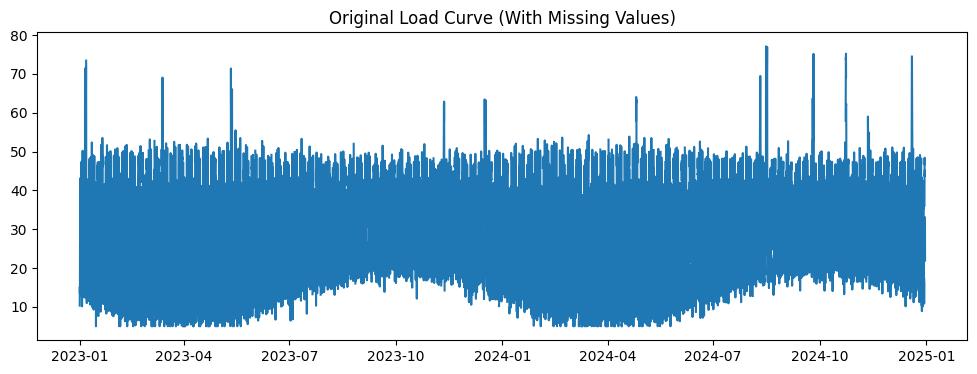

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df['load'])
plt.title("Original Load Curve (With Missing Values)")
plt.show()

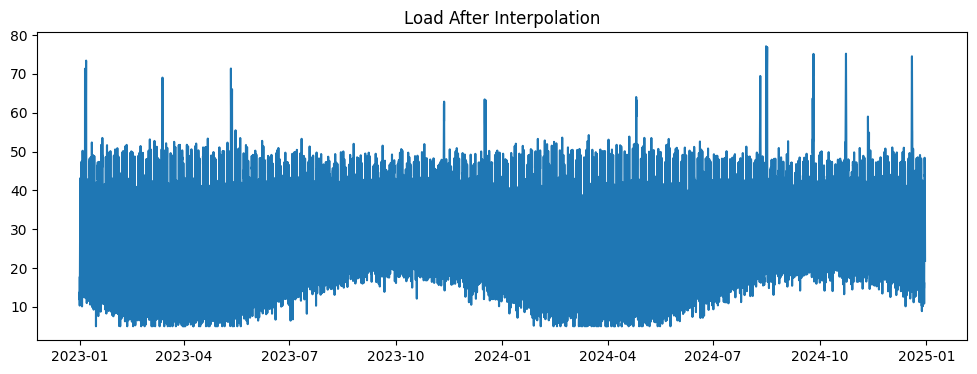

In [ ]:
# Time-based interpolation (best for load curves)
df['load'] = df['load'].interpolate(method='time')
plt.figure(figsize=(12,4))
plt.plot(df['load'])
plt.title("Load After Interpolation")
plt.show()

In [ ]:
# 2. SPLIT TRAIN AND TEST (LAST 7 DAYS FOR TEST)
test_days = 7
test = df['load'][-test_days*24:]   
train = df['load'][:-test_days*24]  

print(f"\nTrain size: {len(train)}   Test size: {len(test)}")



Train size: 17352   Test size: 168


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=(5,1,2)).fit()
print("\n=== ARIMA MODEL SUMMARY ===")
print(arima_model.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using


=== ARIMA MODEL SUMMARY ===
                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                17352
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -42026.848
Date:                Wed, 19 Nov 2025   AIC                          84069.697
Time:                        15:04:01   BIC                          84131.788
Sample:                    01-01-2023   HQIC                         84090.152
                         - 12-23-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3676      0.004    346.042      0.000       1.360       1.375
ar.L2         -0.1762      0.008    -20.814      0.000      -0.193      -0.160
ar.L3         -0.1885  

In [ ]:
# 4. FORECAST FOR LAST 7 DAYS
forecast = arima_model.forecast(steps=len(test))

In [ ]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100  

print("\n=== ARIMA PERFORMANCE ===")
print("MAE  :", mae)
print("RMSE :", rmse)
print("MAPE :", mape, "%")


=== ARIMA PERFORMANCE ===
MAE  : 2.8199933940012945
RMSE : 3.5421069382959227
MAPE : 13.322202089722863 %


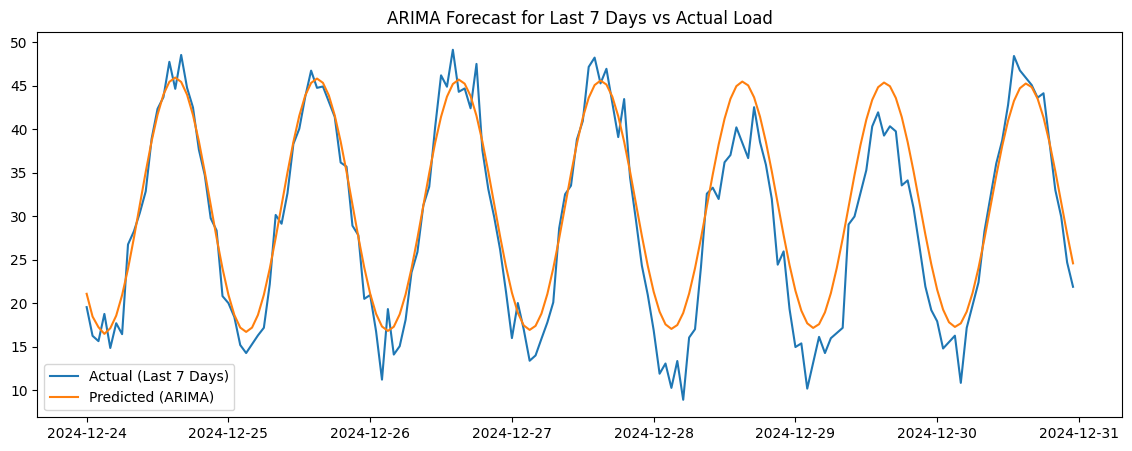

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(test.index, test, label="Actual (Last 7 Days)")
plt.plot(test.index, forecast, label="Predicted (ARIMA)")
plt.title("ARIMA Forecast for Last 7 Days vs Actual Load")
plt.legend()
plt.show()

In [ ]:
import pickle

model_path = "arima_load_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(arima_model, f)

print(f"\nARIMA model saved as: {model_path}")


ARIMA model saved as: arima_load_model.pkl


In [ ]:
forecast_df = pd.DataFrame({
    "Datetime": test.index,
    "Actual_Load": test.values,
    "Predicted_Load": forecast.values
})

csv_path = "arima_last_7_days_forecast.csv"
forecast_df.to_csv(csv_path, index=False)

print(f"\nForecast for last 7 days saved as: {csv_path}")


Forecast for last 7 days saved as: arima_last_7_days_forecast.csv


In [ ]:
model_path = "arima_load_model.pkl"
with open(model_path, "rb") as f:
    arima_model = pickle.load(f)

print("ARIMA model loaded successfully!")

ARIMA model loaded successfully!


In [ ]:
forecast = arima_model.forecast(steps=278)
print(forecast)

2024-12-24 00:00:00    21.079748
2024-12-24 01:00:00    18.462463
2024-12-24 02:00:00    17.239548
2024-12-24 03:00:00    16.474441
2024-12-24 04:00:00    17.121835
                         ...    
2025-01-04 09:00:00    30.798943
2025-01-04 10:00:00    34.289934
2025-01-04 11:00:00    37.574175
2025-01-04 12:00:00    40.428303
2025-01-04 13:00:00    42.658373
Freq: h, Name: predicted_mean, Length: 278, dtype: float64


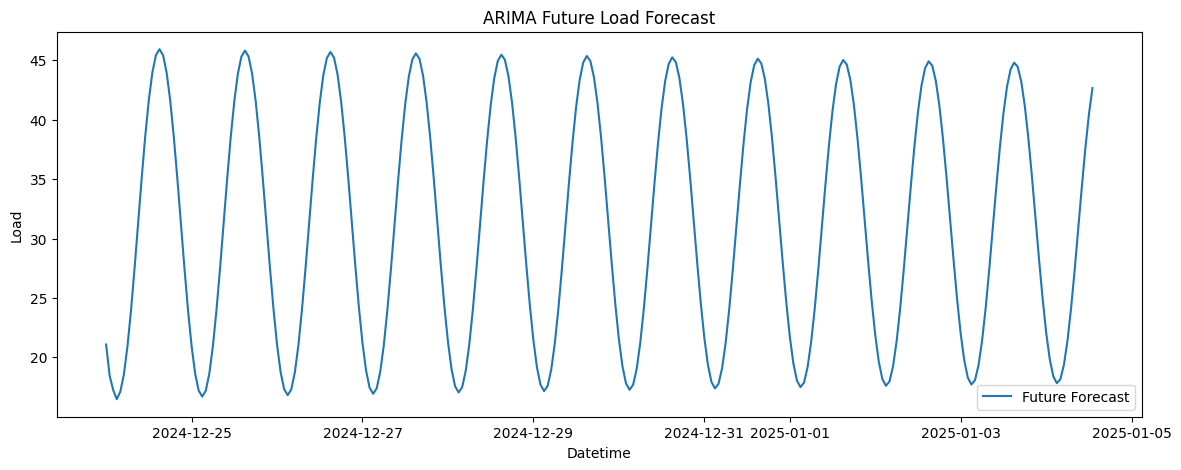

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(forecast, label="Future Forecast")
plt.title("ARIMA Future Load Forecast")
plt.xlabel("Datetime")
plt.ylabel("Load")
plt.legend()
plt.show()